In [1]:
import numpy as np; import sys; import pandas as pd; import os; import networkx as nx; import matplotlib.pyplot as plt;

In [2]:
%matplotlib inline

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
#Load Data

def load_dummy_data(filename):
    """Load data from a .csv file (eventually from an excel file too...).
    Returns the confidences (c) and the score (s)."""
    ext = os.path.splitext(filename)[1]
    if ext == '.csv':
        rawdata = pd.read_csv(filename)
    else:
        rawdata = pd.read_excel(filename)
    #data['No'] = data.No.fillna(method='ffill')
    data = pd.DataFrame({'object':rawdata.iloc[:,0],'assessor':rawdata.iloc[:,1], 'score': rawdata.iloc[:,2], 'confidence':rawdata.iloc[:,3]})
    N_a = len(data.assessor.unique())
    unique_assessor = data.assessor.unique()
    assessor_dict = {unique_assessor[i]:i for i in range(N_a)}
    N_o = len(data.object.unique())
    unique_object = data.object.unique()
    object_dict = {unique_object[i]:i for i in range(N_o)}
    
    c = np.zeros([N_a, N_o])
    s = np.zeros([N_a, N_o])
    data['object'] = data.object.replace(object_dict)
    data['assessor'] = data.assessor.replace(assessor_dict)
    #print data
    lamb = 1.75
    confs = ['h','m','l']
    if any([u in confs for u in data.confidence.unique()]):
        data.confidence.replace({'l':lamb**(-2),'m':1,'h':lamb**(2)}, inplace=True)
    for i in range(data.shape[0]):
        c[data.irow(i).assessor, data.irow(i).object] = data.irow(i).confidence
        s[data.irow(i).assessor, data.irow(i).object] = data.irow(i).score
    
    #print c.shape
    #print c
    return c, s, unique_assessor, unique_object

vals1 = load_dummy_data('inputfile.csv')
c=vals1[0]
s=vals1[1]
unique_assessor=vals1[2]
unique_object=vals1[3]

In [5]:
#Calibtrate Assessors

def calc_values(c, s, degeneracy_condition='default'):
    """Calculate the values from a matrix of confidences (c) and scores (s).
    We are solving the equation L1 * b = Y"""
    N_a = c.shape[0]
    N_o = c.shape[1]
    B = np.zeros([N_a])
    for a in range(0,N_a):
        for o in range(0,N_o):
            B[a] += c[a,o]*s[a,o]

    V = np.zeros([N_o])
    for o in range(0,N_o):
        for a in range(0,N_a):
            V[o] += c[a,o]*s[a,o]

    C = np.zeros([N_o])
    for o in range(0,N_o):
        for a in range(0,N_a):
            C[o] += c[a,o]

    # L1 is the matrix/operator acting on the vector of biases (which we are solving for)
    L1 = np.zeros([N_a, N_a])
    asessor_edge = np.zeros([N_a, N_a])
    for a in range(0,N_a-1):
        for a_ in range(0, N_a):
            temp = 0
            for o in range(0, N_o):
                temp += c[a,o]*c[a_,o]/C[o]
            L1[a,a_] = temp
            asessor_edge[a,a_] = temp
        temp = 0
        for o in range(0, N_o):
            temp += c[a,o]
        L1[a,a] -= temp
    
    for a_ in range(0,N_a):
        temp = 0
        for o_ in range(0,N_o):
            temp += c[N_a-1, o_]*c[a_,o]/C[o]
        asessor_edge[N_a-1,a_] = temp
    
    if degeneracy_condition=='simple':
        # The last row of this system of equations is the condition that b[0]+b[1]+b[2]+... = 0
        L1[N_a-1,:] = 1
    else:
        # The last row of this system of equations is the condition that C'[0]*b[0]+C'[0]*b[1]+C'[0]*b[2]+... = 0
        C_dash = np.zeros([N_a])
        for a_ in range(0,N_a):
            for o_ in range(0, N_o):
                C_dash[a_] += c[a_,o_]
        
            L1[N_a-1,a_] = C_dash[a_]

    # Y is the RHS of the system of equations.
    Y = np.zeros([N_a])
    for a in range(0, N_a-1):
        temp = 0
        for o in range(0,N_o):
            temp += c[a,o]*V[o]/C[o]
        Y[a] = temp - B[a]
    
    # Again, the last row of the system is that the right hand side = 0
    Y[N_a-1] = 0
    
    # Find some way of solving L1 * b = Y. Excel has a matrix inversion command.
    b = np.linalg.solve(L1, Y)
    
    # From the vector of biases, calculate v (the vector of values).
    v = np.zeros([N_o])
    for o in range(0, N_o):
        temp = 0
        for a in range(0, N_a):
            temp += b[a]*c[a,o]
        v[o] = (V[o]-temp)/C[o]

    return b, v,  asessor_edge

vals2=calc_values(c, s, degeneracy_condition='default')
b=vals2[0];v=vals2[1]; assessor_edge=vals2[2]

In [6]:
# Calculate Assessor and Object Total Confidence

def calc_Co_Ca(c):
    """Given confidence matrix `c`, return:
    - `C_o`, the total confidence expressed by assessor `a`
    - `C_a`, the total confidence in the assessment of object `o`"""
    N_a = c.shape[0]
    N_o = c.shape[1]
    C_o = np.zeros((N_o,))
    C_a = np.zeros((N_a,))
    for o in range(N_o):
        for a in range(N_a):
            C_o[o] += c[a,o]
            C_a[a] += c[a,o]
    return C_o, C_a

In [7]:
# Calculate Robustness

def calc_mu_2(c, C_o, C_a):
    """Calculate second-smallest eigenvalue for robustness"""
    N_a = c.shape[0]
    N_o = c.shape[1]
    
    N_m = N_a + N_o
    M = np.zeros((N_m, N_m))
    for i in range(N_m):
        M[i,i] = 1
        
    DT = np.zeros((N_a,N_o))
    
    for a in range(N_a):
        for o in range(N_o):
            DT[a,o] = c[a,o] / np.sqrt(C_o[o]*C_a[a])
    
    #D = np.transpose(DT)
        
    for a in range(N_a):
        for o in range(N_o):
            M[a+N_o,o] = DT[a,o]
            M[o,a+N_o] = DT[a,o]
    eigs = np.linalg.eigvals(M)
    eigs_sorted = np.sort(eigs)
  
    return eigs_sorted[1]

def calc_deltas(c, ds, degeneracy_condition='default'):
    """Calculate upper limits for the change in magnitude of the values and biases vectors,
    given changes in the scores `ds`"""
    N_a, N_o = c.shape
    C_o, C_a = calc_Co_Ca(c)

    total_ds = 0.0
    for a in range(N_a):
        for o in range(N_o):
            total_ds += c[a,o]*(ds[a,o])**2
    mu_2 = calc_mu_2(c, C_o, C_a)
    
    
    if degeneracy_condition=='simple':
        degen_factor = 1.0
    else:
        degen_factor = np.sqrt(2)
        
    
    dv = np.zeros((N_o,))
    for o in range(N_o):
        dv[o] = degen_factor*np.sqrt(total_ds)/np.sqrt(mu_2*C_o[o])
    
    db = np.zeros((N_a,))
    for a in range(N_a):
        db[a] = degen_factor*np.sqrt(total_ds)/np.sqrt(mu_2*C_a[a])
    return db, dv

N_a, N_o = c.shape
ds = np.ones((N_a, N_o))*c.max()*0.01

vals3 = calc_deltas(c,ds)

db=vals3[0];dv=vals3[1]

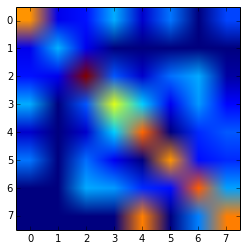

In [8]:
imshow(assessor_edge)

In [9]:
assessor_edge-assessor_edge.T

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.20987654],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.19753086],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.80246914],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -3.49232456],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.03476283],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.17598684],
       [-1.20987654,  0.        , -0.19753086, -0.80246914,  3.49232456,
        -1.03476283, -0.17598684,  0.        ]])

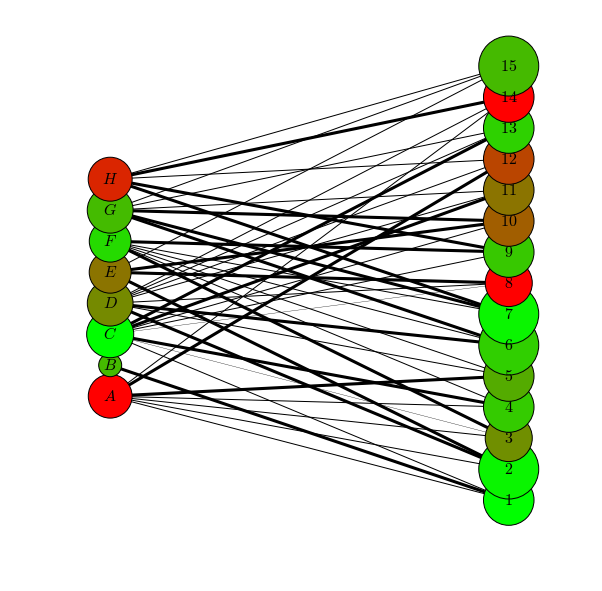

In [10]:
# Calculate Evaluation Graph
def pseudocolor_assessor(val,minval, maxval):
    # convert val in range minval...maxval to range 0..1
    f = float(val-minval) / float(maxval-minval)
    # linearly interpolate that value between the colors red and green
    r, g, b = 1-f, f, 0.
    p = [r, g, b]
    #print p
    return p 

def pseudocolor_object(val,minval, maxval):
    # convert val in range minval...maxval to range 0..1
    f = float(val-minval) / float(maxval-minval)
    # linearly interpolate that value between the colors red and green
    r, g, b = 0., 1-f, f
    p = [r, g, b]
    #print p
    return p 

def evaluation_graph(c,b,v):

    num_nodes = c.shape[0] + c.shape[1]

    # Get the row and column coordinates where the array is not 0.
    rows, cols = np.where(c != 0.00)

    # We label the nodes corresponding to the rows with integers from 0 to
    # c.shape[0]-1, and we label the nodes corresponding to the columns with
    # integers from c.shape[0] to c.shape[0] + c.shape[1] - 1.
    # Rearranges the list of rows and columns into a list of edge tuples.
    edges = zip(rows.tolist(), (cols + c.shape[0]).tolist())
   
    C_o, C_a = calc_Co_Ca(c)
      
    C_o = C_o/np.std(C_o)*500
    C_a = C_a/np.std(C_a)*500
    
    b1 = b/np.std(b)
    v1 = v/np.std(v)

    node_colour_bias = np.zeros([c.shape[0]-1,3])
    node_colour_value = np.zeros([c.shape[1]-1,3])
        
    for x in xrange(0,c.shape[0]-1):
        node_colour_bias[x,0:3]=pseudocolor_assessor(b1[x],b1.min(), b1.max())
    
    for x in xrange(0,c.shape[1]-1):
        node_colour_value[x,0:3]=pseudocolor_assessor(v1[x],v1.min(), v1.max())
    
    node_weight = C_a.tolist() + C_o.tolist()
    node_colour1 = node_colour_bias.tolist() + node_colour_value.tolist()
    edge_weight1 = c[rows, cols]
    #print [rows,cols]
    #print edge_weight1
    #edge_weight1 = edge_weight1 - min(edge_weight1) + 0.1

    # Create a Graph object (from the networkx library).
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes),weight=node_weight)
    G.add_edges_from(edges)

    # Draw the graph.  First create positions for each node. Put the U nodes
    # on the left (x=1) and the V nodes on the right (x=2).

    pos = dict([(k, (1, k*10 - 0.5 * c.shape[0])) for k in range(c.shape[0])])
    pos.update(dict([(k + c.shape[0], (2, k*10 - 5*0.5*c.shape[1])) for k in range(c.shape[1])]))

    labels={}
    labels[0]=r'$A$'
    labels[1]=r'$B$'
    labels[2]=r'$C$'
    labels[3]=r'$D$'
    labels[4]=r'$E$'
    labels[5]=r'$F$'
    labels[6]=r'$G$'
    labels[7]=r'$H$'
    labels[8]=r'$1$'
    labels[9]=r'$2$'
    labels[10]=r'$3$'
    labels[11]=r'$4$'
    labels[12]=r'$5$'
    labels[13]=r'$6$'
    labels[14]=r'$7$'
    labels[15]=r'$8$'
    labels[16]=r'$9$'
    labels[17]=r'$10$'
    labels[18]=r'$11$'
    labels[19]=r'$12$'
    labels[20]=r'$13$'
    labels[21]=r'$14$'
    labels[22]=r'$15$'
    
    plt.figure(figsize=[10,10])
    nx.draw_networkx(G, pos=pos, node_color=node_colour1,node_size=node_weight,width=edge_weight1,font_color='k',font_weight='bold', with_labels=False)
    nx.draw_networkx_labels(G,pos,labels,font_size=16)
    plt.axis('off')
    plt.show()
    return 

evaluation_graph(c,b,v)

[ 4.56850026  0.50740741  0.77933525  1.7397011   0.3322937   1.40270055
  1.11234568  1.75509259  0.50740741  6.10151788  1.18674266  0.32784074
  1.34018642  1.71728395  0.1         3.75063964  1.91656913  0.52982456
  1.61386858  0.70493827  4.86957242  0.93723197  1.21880686  4.56775305
  0.76211826  0.93723197  4.92318064  1.64863142  4.71113142]
[(0, 0, {}), (0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 4, {}), (0, 5, {}), (0, 7, {}), (1, 1, {}), (1, 2, {}), (2, 2, {}), (2, 3, {}), (2, 4, {}), (2, 5, {}), (2, 6, {}), (2, 7, {}), (3, 3, {}), (3, 4, {}), (3, 5, {}), (3, 6, {}), (3, 7, {}), (4, 4, {}), (4, 6, {}), (4, 7, {}), (5, 5, {}), (5, 6, {}), (5, 7, {}), (6, 6, {}), (6, 7, {}), (7, 7, {})]


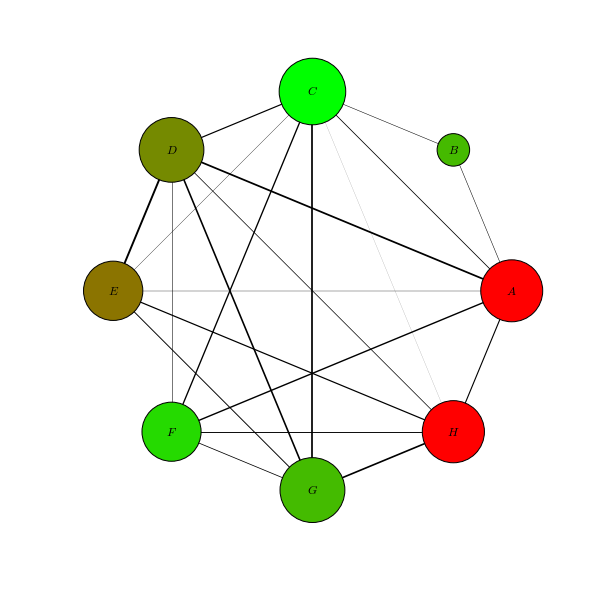

In [11]:
# Calculate Assessor Graph

def pseudocolor(val,minval, maxval):
    # convert val in range minval...maxval to range 0..1
    f = float(val-minval) / float(maxval-minval)
    # linearly interpolate that value between the colors red and green
    r, g, b = 1-f, f, 0.
    p = [r, g, b]
    return p 

def assessor_graph(assessor_edge,c,b,v):

    num_nodes = assessor_edge.shape[0]

    # Get the row and column coordinates where the array is not 0.
    rows, cols = np.where(assessor_edge != 0)

    # We label the nodes corresponding to the rows with integers from 0 to
    # c.shape[0]-1, and we label the nodes corresponding to the columns with
    # integers from c.shape[0] to c.shape[0] + c.shape[1] - 1.
    # Rearranges the list of rows and columns into a list of edge tuples.
    edges = zip(rows.tolist(), cols.tolist())

    C_o, C_a = calc_Co_Ca(c)

    C_a = C_a/np.std(C_a)*1000 
    b1 = b/np.std(b)

    node_colour1 = np.zeros([assessor_edge.shape[0]-1,3])

    for x in xrange(0,assessor_edge.shape[0]-1):
        node_colour1[x,0:3]=pseudocolor(b1[x],b1.min(), b1.max())

    node_weight = C_a.tolist() 
    edge_weight1 = assessor_edge[rows,cols]
    edge_weight1 = edge_weight1 - min(edge_weight1) + 0.1
    print edge_weight1
    # Create a Graph object (from the networkx library).
    G1 = nx.Graph()
    G1.add_nodes_from(range(num_nodes),weight=node_weight)
    G1.add_edges_from(edges)
    print G1.edges(data=True)
        # some math labels
    labels={}
    labels[0]=r'$A$'
    labels[1]=r'$B$'
    labels[2]=r'$C$'
    labels[3]=r'$D$'
    labels[4]=r'$E$'
    labels[5]=r'$F$'
    labels[6]=r'$G$'
    labels[7]=r'$H$'
    
    plt.figure(figsize=[10,10])
    position = nx.circular_layout(G1)
    nx.draw_networkx(G1, position, node_color=node_colour1,node_size=node_weight,width=edge_weight1,with_labels=False)
    nx.draw_networkx_labels(G1,position,labels=labels)
    
    plt.axis('off')
    plt.colorbar
    plt.show()
    return

assessor_graph(np.triu(assessor_edge),c,b,v)

In [12]:
c_conn=(c>0)
c_conn.dot(1.0*c_conn.T)

array([[ 7.,  1.,  3.,  4.,  1.,  3.,  0.,  2.],
       [ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  1.,  8.,  3.,  2.,  3.,  3.,  1.],
       [ 4.,  0.,  3.,  8.,  2.,  2.,  3.,  2.],
       [ 1.,  0.,  2.,  2.,  4.,  0.,  2.,  1.],
       [ 3.,  0.,  3.,  2.,  0.,  6.,  2.,  2.],
       [ 0.,  0.,  3.,  3.,  2.,  2.,  6.,  2.],
       [ 2.,  0.,  1.,  2.,  1.,  2.,  2.,  5.]])

In [13]:
def get_neighbour_mat(c):
    c_conn = (c>0)
    common = c_conn.dot(1.0*c_conn.T)
    np.fill_diagonal(common,0)
    tot_c = c.dot(c.T)
    out = tot_c/common
    out[tot_c==0] = 0
    np.fill_diagonal(out,0)
    return out
    

In [14]:
assessor_edge

array([[ 4.66603113,  0.60493827,  0.87686611,  1.83723197,  0.42982456,
         1.50023141,  0.        ,  1.20987654],
       [ 0.60493827,  1.85262346,  0.60493827,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.87686611,  0.60493827,  6.19904874,  1.28427352,  0.42537161,
         1.43771729,  1.81481481,  0.19753086],
       [ 1.83723197,  0.        ,  1.28427352,  3.8481705 ,  2.0141    ,
         0.62735543,  1.71139945,  0.80246914],
       [ 0.42982456,  0.        ,  0.42537161,  2.0141    ,  4.96710328,
         0.        ,  1.03476283,  1.31633772],
       [ 1.50023141,  0.        ,  1.43771729,  0.62735543,  0.        ,
         4.66528392,  0.85964912,  1.03476283],
       [ 0.        ,  0.        ,  1.81481481,  1.71139945,  1.03476283,
         0.85964912,  5.0207115 ,  1.74616228],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  4.80866228,
         0.        ,  1.57017544,  4.80866228]])

In [15]:
s - np.tile(s.mean(axis=1),(15,1)).T

array([[ 2.4       ,  5.4       ,  4.4       ,  3.4       ,  4.9       ,
        -3.6       , -3.6       , -3.6       , -3.6       , -3.6       ,
        -3.6       ,  3.4       , -3.6       ,  4.9       , -3.6       ],
       [ 6.53333333, -0.46666667, -0.46666667, -0.46666667, -0.46666667,
        -0.46666667, -0.46666667, -0.46666667, -0.46666667, -0.46666667,
        -0.46666667, -0.46666667, -0.46666667, -0.46666667, -0.46666667],
       [ 3.21333333, -4.28666667,  3.21333333,  4.51333333, -4.28666667,
        -4.28666667, -4.28666667,  5.71333333,  1.71333333,  4.21333333,
         3.71333333, -4.28666667,  3.71333333, -4.28666667, -4.28666667],
       [-4.48      ,  5.02      , -4.48      , -4.48      ,  4.72      ,
         3.52      , -4.48      ,  5.02      , -4.48      , -4.48      ,
         2.52      ,  3.52      ,  1.52      ,  5.52      , -4.48      ],
       [-2.36666667,  6.63333333, -2.36666667, -2.36666667, -2.36666667,
        -2.36666667, -2.36666667,  6.63333333, 

In [16]:

from scipy import sparse

In [17]:
import calibration_robust as cr

In [18]:
c,s,u_a, u_o = cr.load_dummy_data('./inputfile.csv')

In [19]:
calib = cr.run_calibration(c,s,u_a, u_o)

In [20]:
c_o, c_a = cr.calc_Co_Ca(c)

In [21]:
calib['b']['c_a'] = c_a
calib['v']['c_o'] = c_o

In [22]:
b_nodes = calib['b'].to_dict('records')
v_nodes = calib['v'].to_dict('records')

In [23]:
pos_l

NameError: name 'pos_l' is not defined

In [24]:
assess, ob = np.where(c>=0)
edge_list = []

G = nx.Graph()
G.add_nodes_from([(x['Assessor'],{'bias':x['Bias'],'c_a':x['c_a']}) for x in b_nodes]
                 ,kind='assessor')


G.add_nodes_from([(int(x['Object']),{'value':x['Values'],'c_o':x['c_o']}) for x in v_nodes]
                 ,kind='object')
for edge in zip(assess,ob):
    conf = c[edge[0],edge[1]]
    if conf > 0:
        new_edge = (u_a[edge[0]], u_o[edge[1]],{'confidence': conf})
        edge_list.append(new_edge)
    
G.add_edges_from(edge_list)


G_neigh = nx.Graph()
G_neigh.add_nodes_from([(x['Assessor'],{'bias':x['Bias'],'c_a':x['c_a']}) for x in b_nodes]
                 ,kind='assessor')

neighbour = get_neighbour_mat(c)
neighbour = np.triu(assessor_edge)

for a in range(c.shape[0]):
    for a_other in range(c.shape[0]):
        neigh = neighbour[a,a_other]
        if neigh>0:
            G_neigh.add_edge(u_a[a],u_a[a_other],{'shared':neigh})

fig = figure(figsize=(12,10))
pos = nx.circular_layout(G_neigh)
nodes_a_vals = node_values(G_neigh)
vrange_a = max(np.abs(nodes_a_vals))
node_plt = nx.draw_networkx_nodes(G_neigh,pos,
                 node_size=get_scaled_property(G_neigh,'c_a',xmin=500,xmax=1000),
                node_color=nodes_a_vals,vmin=-vrange_a,vmax=vrange_a,
                                  cmap=cm.RdBu)
edge_plt =  nx.draw_networkx_edges(G_neigh,pos,
                                   width=scale_property(edge_values(G_neigh,prop='shared'),
                                                        xmin=0.1,xmax=10),
                                   edge_color='#333333')

dark_nodes = [node[0] for node in G_neigh.nodes(data=True) if abs(node[1]['bias'])>0.5*vrange_a]
pos_d = {n:pos[n] for n in dark_nodes}
light_nodes = [node[0] for node in G_neigh.nodes(data=True) if abs(node[1]['bias'])<=0.5*vrange_a]
pos_l = {n:pos[n] for n in light_nodes}
lbl_plt_l = nx.draw_networkx_labels(G_neigh.subgraph(light_nodes),pos_l,font_color='#000000',font_size=20)
lbl_plt_d = nx.draw_networkx_labels(G_neigh.subgraph(dark_nodes),pos_d,font_color='#FFFFFF',font_size=20)
_ = axis('off')
fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.9,0.2,0.05,0.7])
cb1 = fig.colorbar(node_plt,cax=cbar_ax1)
cb1.set_label("Bias")
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_conn.pdf",bbox_inches='tight')
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_conn.svg",bbox_inches='tight')
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_conn.png",bbox_inches='tight')


NameError: name 'node_values' is not defined

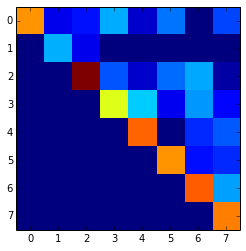

In [25]:
imshow(np.triu(assessor_edge),interpolation='nearest')

In [26]:

def _node_value(node):
    if node[1]['kind'] == 'assessor':
        return node[1]['bias']
    else:
        return node[1]['value']
    
def get_node_property(G,prop):
    return [node[1][prop] for node in G.nodes(data=True)]

def scale_property(out, xmin=300,xmax=500):
    minx = out.min()
    maxx = out.max()
    dx = maxx-minx
    dx_new = xmax-xmin
    return 1.0*(out-minx)*(1.0*dx_new/dx)+xmin
    
def get_scaled_property(G,prop,xmin=300,xmax=500):
    out = np.asarray(get_node_property(G,prop))
    return scale_property(out, xmin=xmin, xmax=xmax)

def node_values(G):
    return [_node_value(node) for node in G.nodes(data=True)]

def edge_values(G,prop='confidence'):
    out = np.asarray([edge[2][prop] for edge in G.edges(data=True)])
    return out

def shift_pos(pos,dx=0,dy=0):
    newpos = pos.copy()
    return {k:(v[0]+dx,v[1]+dy) for k,v in pos.iteritems()}


In [27]:
shift_text(all_pos,dx=-10)

NameError: name 'shift_text' is not defined

In [42]:
{n:i for i,n in enumerate(G_a.node)}

{'A': 0, 'B': 2, 'C': 1, 'D': 4, 'E': 3, 'F': 6, 'G': 5, 'H': 7}

IOError: [Errno 2] No such file or directory: '/Users/danybol/workspace/spectra/coventry/assess_obj.pdf'

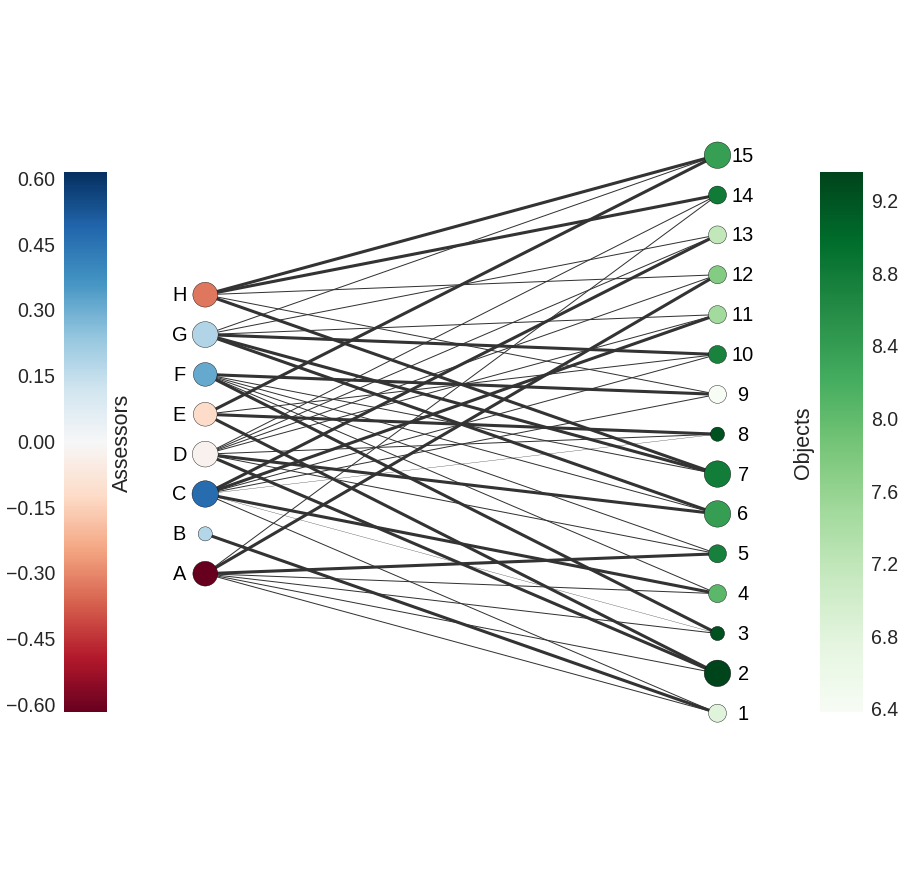

In [31]:
# import seaborn
seaborn.set_context("talk",font_scale=1.5)

ypos_a = np.linspace(10,30,num=len(u_a))
ypos_o = np.linspace(0,40,num=len(u_o))

pos_a = {u_a[i]:(0,ypos_a[i]) for i in range(len(u_a))}
pos_o = {u_o[i]:(10,ypos_o[i]) for i in range(len(u_o))}
#pos_a.update(pos_o)
all_pos = pos_a.copy()
all_pos.update(pos_o)
G_a = G.subgraph([k for k,v in G.node.items() if v['kind']=='assessor'])
G_o = G.subgraph([k for k,v in G.node.items() if v['kind']=='object'])
fig = figure(figsize=(12,15))
#gs = matplotlib.gridspec.GridSpec(1,3,width_ratios=[1,5,1])
ax2 = fig.add_subplot(111)
#ax2 = subplot(gs[1])
#ax3 = subplot(gs[2])
nodes_a_vals = node_values(G_a)
vrange_a = max(np.abs(nodes_a_vals))
nodes_a = nx.draw_networkx_nodes(G_a,ax=ax2,pos=pos_a,
                                 node_color=node_values(G_a),
                                 node_size=get_scaled_property(G_a,'c_a',xmin=200,xmax=700),
                                 cmap=cm.RdBu,vmin=-vrange_a,vmax=vrange_a,
                                )
nodes_o = nx.draw_networkx_nodes(G_o,ax=ax2,pos=pos_o,node_color=node_values(G_o),
                                 cmap=cm.Greens,
                                node_size=get_scaled_property(G_o,'c_o',xmin=200,xmax=700),)
edges = nx.draw_networkx_edges(G,ax=ax2,pos=all_pos,width=edge_values(G),edge_color='#333333')
nx.draw_networkx_labels(G_a,shift_pos(pos_a,dx=-0.5),font_size=20)
nx.draw_networkx_labels(G_o,shift_pos(pos_o,dx=0.5),font_size=20)

#ax1.axis('off')
ax2.axis('off')
#ax3.axis('off')
fig.subplots_adjust(left=0.07,right=0.9)
cbar_ax1 = fig.add_axes([0.9,0.255,0.05,0.5])
cbar_ax2 = fig.add_axes([0.025,0.255,0.05,0.5])
cb1 = fig.colorbar(nodes_o,cax=cbar_ax1)
cb1.set_label('Objects')
cb1.ax.yaxis.set_label_position("left")
cb2 = fig.colorbar(nodes_a,cax=cbar_ax2)
cb2.ax.yaxis.set_ticks_position("left")
cb2.ax.yaxis.set_label_position("right")
cb2.set_label("Assessors",)
fig.subplots_adjust()
#colorbar(nodes_o)
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_obj.pdf",bbox_inches='tight')
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_obj.svg",bbox_inches='tight')
fig.savefig("/Users/danybol/workspace/spectra/coventry/assess_obj.png",bbox_inches='tight')



In [30]:
import seaborn

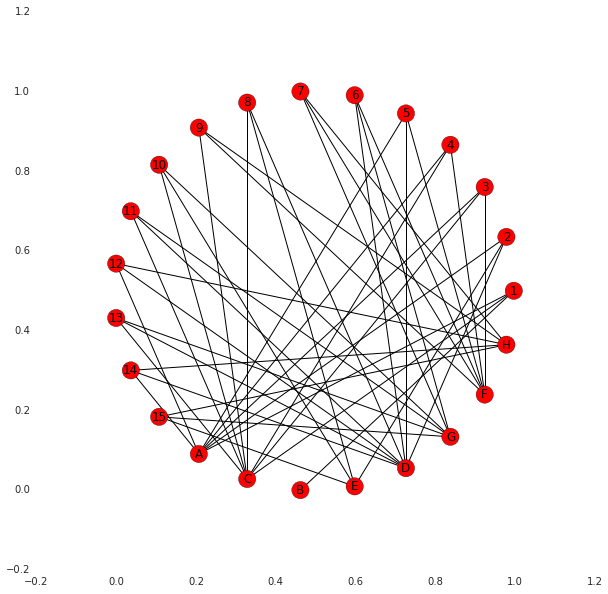

In [109]:
plt.figure(figsize=[10,10])
position = nx.circular_layout(G)
nx.draw_networkx(G, position)
    

In [84]:
np.asarray(zip(*np.where(c)))

array([[ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 0,  3],
       [ 0,  4],
       [ 0, 11],
       [ 0, 13],
       [ 1,  0],
       [ 2,  0],
       [ 2,  2],
       [ 2,  3],
       [ 2,  7],
       [ 2,  8],
       [ 2,  9],
       [ 2, 10],
       [ 2, 12],
       [ 3,  1],
       [ 3,  4],
       [ 3,  5],
       [ 3,  7],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 13],
       [ 4,  1],
       [ 4,  7],
       [ 4,  9],
       [ 4, 14],
       [ 5,  2],
       [ 5,  3],
       [ 5,  4],
       [ 5,  5],
       [ 5,  6],
       [ 5,  8],
       [ 6,  5],
       [ 6,  6],
       [ 6,  9],
       [ 6, 10],
       [ 6, 12],
       [ 6, 14],
       [ 7,  6],
       [ 7,  8],
       [ 7, 11],
       [ 7, 13],
       [ 7, 14]])

In [67]:
edge_list

[('A', 1),
 ('A', 2),
 ('A', 3),
 ('A', 4),
 ('A', 5),
 ('A', 12),
 ('A', 14),
 ('B', 1),
 ('C', 1),
 ('C', 3),
 ('C', 4),
 ('C', 8),
 ('C', 9),
 ('C', 10),
 ('C', 11),
 ('C', 13),
 ('D', 2),
 ('D', 5),
 ('D', 6),
 ('D', 8),
 ('D', 11),
 ('D', 12),
 ('D', 13),
 ('D', 14),
 ('E', 2),
 ('E', 8),
 ('E', 10),
 ('E', 15),
 ('F', 3),
 ('F', 4),
 ('F', 5),
 ('F', 6),
 ('F', 7),
 ('F', 9),
 ('G', 6),
 ('G', 7),
 ('G', 10),
 ('G', 11),
 ('G', 13),
 ('G', 15),
 ('H', 7),
 ('H', 9),
 ('H', 12),
 ('H', 14),
 ('H', 15)]

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E',
       'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F', 'G', 'G', 'G', 'G', 'G',
       'G', 'H', 'H', 'H', 'H', 'H'], dtype=object)

array([ 1,  2,  3,  4,  5, 12, 14,  1,  1,  3,  4,  8,  9, 10, 11, 13,  2,
        5,  6,  8, 11, 12, 13, 14,  2,  8, 10, 15,  3,  4,  5,  6,  7,  9,
        6,  7, 10, 11, 13, 15,  7,  9, 12, 14, 15])